In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from math import radians, log10
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def rate(episodes, episode, min_value):
    return max(min_value, min(1., 1. - log10((episode + 1) * 10 / episodes)))

In [3]:
class QLearningCartPole:
    def __init__(self, min_alpha=0.1, gamma=1.0, min_epsilon=0.01, episodes=200, bins=(6, 12)):
        self.min_alpha = min_alpha  # Learning rate will decrease from 1 to this value over time
        self.gamma = gamma  # Discount factor (0 <= 𝛾 <= 1)
        self.min_epsilon = min_epsilon  # Exploration rate will decrease from 1 to this value over time
        self.episodes = episodes  # Epochs, times to run

        self.env = gym.make("CartPole-v1", render_mode="human")
        self.env.action_space.seed(42)
        self.bins = bins  # Number of bins to divide continuous sizes into.
        self.obs_min = [self.env.observation_space.low[2], -radians(50)]
        self.obs_max = [self.env.observation_space.high[2], radians(50)]

        self.q_table = np.zeros(self.bins + (self.env.action_space.n,))
        self.rewards = []

    def discretize_observation(self, cart_pos, cart_vel, pole_ang, pole_vel):
        kbins = KBinsDiscretizer(n_bins=self.bins, encode='ordinal', strategy='uniform')
        kbins.fit([self.obs_min, self.obs_max])

        return tuple(map(int, kbins.transform([[pole_ang, pole_vel]])[0]))

    def bellman(self, episode, q_old, r, max_q_next):
        return (1 - self.learning_rate(episode)) * q_old + self.learning_rate(episode) * (r + self.gamma * max_q_next)

    def learning_rate(self, episode):
        return rate(self.episodes, episode, self.min_alpha)

    def exploration_rate(self, episode):
        return rate(self.episodes, episode, self.min_epsilon)

    def action(self, episode, observation):
        if np.random.random() > self.exploration_rate(episode):
            return np.argmax(self.q_table[observation])
        else:
            return self.env.action_space.sample()

    def train(self):
        for episode in range(self.episodes):
            obs = self.discretize_observation(*[i for i in self.env.reset()[0]])
            done = False
            episode_reward = 0

            while not done:
                action = self.action(episode, obs)  # Get an action based on the current observation
                new_obs, reward, done, _, _ = self.env.step(action)  # Perform the given action
                new_obs = self.discretize_observation(*new_obs)  # Discretize observation

                q_old = self.q_table[obs][action]
                max_q_next = np.max(self.q_table[new_obs])
                self.q_table[obs][action] = self.bellman(episode, q_old, reward, max_q_next)

                obs = new_obs
                episode_reward += 1  # Each time step grants a reward in CartPole.

            print(f"Episode {episode + 1} gave reward {episode_reward} (lr={self.learning_rate(episode)}  er={self.exploration_rate(episode)}).")
            self.rewards.append(episode_reward)
            self.env.render()

        self.env.close()

    def run(self):
        current_observation = self.discretize_observation(*[i for i in self.env.reset()[0]])
        done = False

        while not done:
            self.env.render()
            action = self.action(*current_observation)
            observation, reward, done, info, _ = self.env.step(action)
            current_observation = self.discretize_observation(*observation)

Episode 1 gave reward 24 (lr=1.0  er=1.0).
Episode 2 gave reward 25 (lr=1.0  er=1.0).
Episode 3 gave reward 25 (lr=1.0  er=1.0).
Episode 4 gave reward 30 (lr=1.0  er=1.0).
Episode 5 gave reward 11 (lr=1.0  er=1.0).
Episode 6 gave reward 55 (lr=1.0  er=1.0).
Episode 7 gave reward 29 (lr=1.0  er=1.0).
Episode 8 gave reward 34 (lr=1.0  er=1.0).
Episode 9 gave reward 45 (lr=1.0  er=1.0).
Episode 10 gave reward 10 (lr=1.0  er=1.0).
Episode 11 gave reward 53 (lr=1.0  er=1.0).
Episode 12 gave reward 17 (lr=1.0  er=1.0).
Episode 13 gave reward 30 (lr=1.0  er=1.0).
Episode 14 gave reward 32 (lr=1.0  er=1.0).
Episode 15 gave reward 15 (lr=1.0  er=1.0).
Episode 16 gave reward 44 (lr=1.0  er=1.0).
Episode 17 gave reward 12 (lr=1.0  er=1.0).
Episode 18 gave reward 38 (lr=1.0  er=1.0).
Episode 19 gave reward 19 (lr=1.0  er=1.0).
Episode 20 gave reward 13 (lr=1.0  er=1.0).
Episode 21 gave reward 10 (lr=0.978810700930062  er=0.978810700930062).
Episode 22 gave reward 11 (lr=0.958607314841775  er=0.958

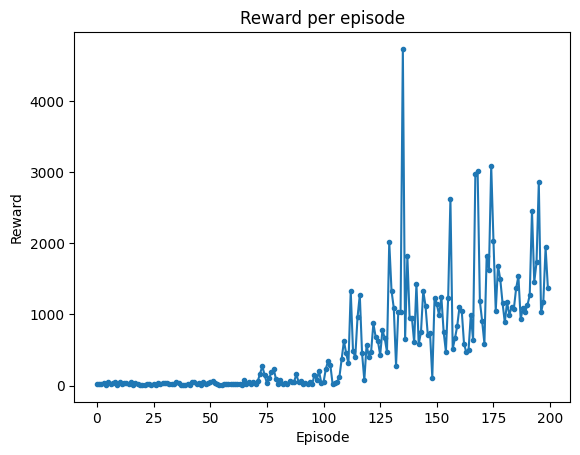

In [4]:
ql = QLearningCartPole()
ql.train()

plt.figure()
plt.plot(range(0, ql.episodes), ql.rewards, marker=".")
plt.title("Reward per episode")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
